
# Analisis de optimización del chunk size en el RAG

Este análisis investiga cómo influye el tamaño del fragmento (`chunk_size`) en el rendimiento y calidad de un sistema de Recuperación-Augmentada con Generación (RAG) aplicado a un tutor inteligente de estructuras de datos y algoritmos.

### Objetivos
- Comparar distintos tamaños de `chunk` para medir su impacto en:
  - Tiempo de recuperación.
  - Puntaje de similitud.
  - Calidad de las respuestas generadas.
- Determinar un `chunk_size` óptimo que balancee velocidad y relevancia.


In [12]:

import os
from dotenv import dotenv_values
from utils.document_load import load_documents
from utils.embedding_loader import embedding_loader
from utils.chunking.globals import test_queries, test_chunk_sizes
from utils.chunking.chunk_optimization import (
    evaluate_answer_quality,
    evaluate_chunk_size_performance,
    calculate_optimization_score,
    create_performance_visualizations,
    analyze_chunk_stats
)
from utils.chunking.chunking import chunk_with_different_sizes, create_vector_stores, chunk_docs

documents = load_documents("../data/algoritmos")
print(f"[DEBUG]{len(documents)} documentos cargados.")

config = dotenv_values("../.env")
os.environ["GOOGLE_API_KEY"] = config["GOOGLE_API_KEY_1"]

chunked_docs = chunk_with_different_sizes(documents, test_chunk_sizes)
vector_stores = create_vector_stores(chunked_docs)

Documentos PDF cargados: 0
Documentos Markdown cargados: 165
[DEBUG]165 documentos cargados.
Embeddings configurados correctamente
[DEBUG] Creating vector store for chunk size 128...
[DEBUG] Vector store created with 14620 chunks
[DEBUG] Creating vector store for chunk size 256...
[DEBUG] Vector store created with 7707 chunks
[DEBUG] Creating vector store for chunk size 512...
[DEBUG] Vector store created with 3720 chunks
[DEBUG] Creating vector store for chunk size 1024...
[DEBUG] Vector store created with 1694 chunks


In [13]:
# obtenemos algunas estadisticas de los chunks
chunk_stats_df = analyze_chunk_stats(chunked_docs)
chunk_stats_df

print("Chunk Statistics:")
print(chunk_stats_df.round(2))

Chunk Statistics:
   chunk_size  num_chunks  avg_length  min_length  max_length  std_length
0         128       14620       96.04           1         127       36.42
1         256        7707      182.54           3         255       73.52
2         512        3720      375.83           5         512      128.17
3        1024        1694      827.97          14        1023      204.95


In [14]:
# Evaluamos el rendimiento con diferentes tamaños de chunk
from random import sample
sampled_queries = sample(test_queries, 3)
performance_df = evaluate_chunk_size_performance(vector_stores, sampled_queries)
print("\nPerformance Results:")
print(performance_df.groupby('chunk_size').agg({
    'retrieval_time': 'mean',
    'avg_similarity_score': 'mean',
    'avg_chunk_length': 'mean'
}).round(4))

[DEBUG] Testing query: 'Can you give me exercises to practice AVL trees?...'
[DEBUG] Testing query: 'Could you explain Dijkstra's algorithm with an exa...'
[DEBUG] Testing query: 'What does it mean for an algorithm to be stable?...'

Performance Results:
            retrieval_time  avg_similarity_score  avg_chunk_length
chunk_size                                                        
128                 0.0466                0.7882           70.5556
256                 0.0238                0.8605          143.4444
512                 0.0321                0.9409          266.7778
1024                0.0310                1.0479          813.2222


In [15]:

from langchain_google_genai import ChatGoogleGenerativeAI

sampled_queries = sample(test_queries, 3)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
qa_df = evaluate_answer_quality(vector_stores, sampled_queries, llm=llm)

for size in test_chunk_sizes:
    print(f"\n{'='*50}")
    print(f"CHUNK SIZE: {size}")
    print(f"{'='*50}")

    size_results = qa_df[qa_df['chunk_size'] == size]

    for _, row in size_results.iterrows():
        print(f"\nQ: {row['question']}")
        print(f"A: {row['answer']}")
        print(f"Context length: {row['context_length']} chars | Time: {row['answer_time']:.2f}s")



Evaluating: Could you explain Dijkstra's algorithm with an example?

Evaluating: How do I implement a stack using only queues?

Evaluating: Can you compare mergesort and heapsort?

CHUNK SIZE: 128

Q: Could you explain Dijkstra's algorithm with an example?
A: The provided text only mentions Dijkstra's algorithm and its complexity, not its mechanics.  Therefore, I cannot explain Dijkstra's algorithm with an example based on this context alone.
Context length: 373 chars | Time: 2.05s

Q: How do I implement a stack using only queues?
A: The provided text describes using two stacks to simulate a queue, not the reverse.  It does not offer information on implementing a stack using only queues.
Context length: 245 chars | Time: 0.90s

Q: Can you compare mergesort and heapsort?
A: The provided text focuses on heap merging, not a direct comparison of mergesort and heapsort.  Therefore, a comparison cannot be made based solely on this context.
Context length: 379 chars | Time: 0.92s

CHUNK SIZE


# Análisis de Varianza (ANOVA)

Para determinar si el tamaño del chunk tiene un impacto significativo en métricas clave, como el **tiempo de respuesta** o la **longitud del contexto**, aplicamos un **ANOVA de una vía**.

Este análisis permite comparar las medias entre varios grupos (en este caso, distintos `chunk_size`) y verificar si las diferencias observadas son estadísticamente significativas.


In [16]:

from scipy.stats import f_oneway

# Agrupar tiempo de respuesta por chunk size
groups_answer_time = [
    qa_df[qa_df.chunk_size == size]["answer_time"].dropna().values
    for size in sorted(qa_df.chunk_size.unique())
]

# ANOVA para tiempo de respuesta
f_stat_time, p_val_time = f_oneway(*groups_answer_time)

print(f"🔍 ANOVA Tiempo de Respuesta → F = {f_stat_time:.4f}, p = {p_val_time:.4f}")
if p_val_time < 0.05:
    print("Hay diferencias estadísticamente significativas entre los tamaños de chunk.")
else:
    print("No se encontraron diferencias significativas entre los tamaños de chunk.")


# Agrupar longitud del contexto por chunk size
groups_context_len = [
    qa_df[qa_df.chunk_size == size]["context_length"].dropna().values
    for size in sorted(qa_df.chunk_size.unique())
]

# ANOVA para longitud del contexto
f_stat_ctx, p_val_ctx = f_oneway(*groups_context_len)

print(f"🔍 ANOVA Longitud de Contexto → F = {f_stat_ctx:.4f}, p = {p_val_ctx:.4f}")
if p_val_ctx < 0.05:
    print("✅ Hay diferencias estadísticamente significativas en longitud del contexto.")
else:
    print("❌ No hay diferencias significativas en longitud del contexto.")


🔍 ANOVA Tiempo de Respuesta → F = 3.3504, p = 0.0762
No se encontraron diferencias significativas entre los tamaños de chunk.
🔍 ANOVA Longitud de Contexto → F = 63.4456, p = 0.0000
✅ Hay diferencias estadísticamente significativas en longitud del contexto.


### 🧪 Intervalos de Confianza para la Similitud

Con el objetivo de evaluar la estabilidad del puntaje de similitud promedio (`avg_similarity_score`) entre distintos tamaños de fragmento (`chunk_size`), aplicamos bootstrapping para estimar intervalos de confianza del 95%.

Esto nos permite analizar con mayor solidez si las diferencias observadas en la similitud son estadísticamente consistentes y relevantes.

Chunk size 128: mean=0.7882, CI 95% = (0.4654, 0.9937)
Chunk size 256: mean=0.8605, CI 95% = (0.5394, 1.0933)
Chunk size 512: mean=0.9409, CI 95% = (0.6082, 1.1597)
Chunk size 1024: mean=1.0479, CI 95% = (0.7028, 1.2278)


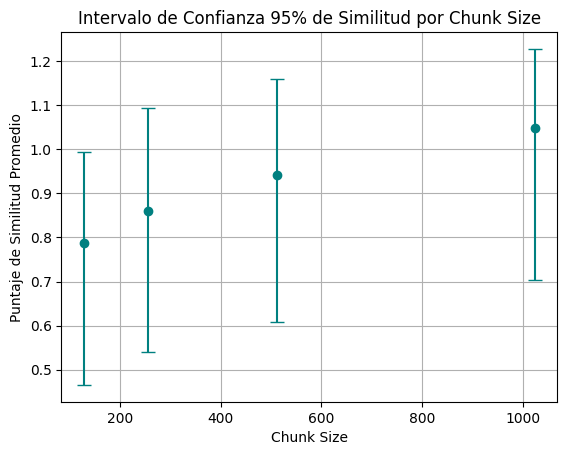

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def bootstrap_ci(data, n_resamples=1000, ci=0.95):
    means = []
    n = len(data)
    for _ in range(n_resamples):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    lower = np.percentile(means, ((1 - ci) / 2) * 100)
    upper = np.percentile(means, (1 - (1 - ci) / 2) * 100)
    return lower, upper

# Calcular intervalo de confianza por chunk_size
ci_results = []
for size in sorted(performance_df.chunk_size.unique()):
    sim_scores = performance_df[performance_df.chunk_size == size]["avg_similarity_score"].dropna().values
    if len(sim_scores) > 0:
        lower, upper = bootstrap_ci(sim_scores)
        mean = np.mean(sim_scores)
        ci_results.append((size, mean, lower, upper))

# Mostrar resultados
for size, mean, lower, upper in ci_results:
    print(f"Chunk size {size}: mean={mean:.4f}, CI 95% = ({lower:.4f}, {upper:.4f})")

# Visualizar
sizes = [r[0] for r in ci_results]
means = [r[1] for r in ci_results]
lowers = [r[1] - r[2] for r in ci_results]
uppers = [r[3] - r[1] for r in ci_results]

plt.errorbar(sizes, means, yerr=[lowers, uppers], fmt='o', capsize=5, color='teal')
plt.title("Intervalo de Confianza 95% de Similitud por Chunk Size")
plt.xlabel("Chunk Size")
plt.ylabel("Puntaje de Similitud Promedio")
plt.grid(True)
plt.show()


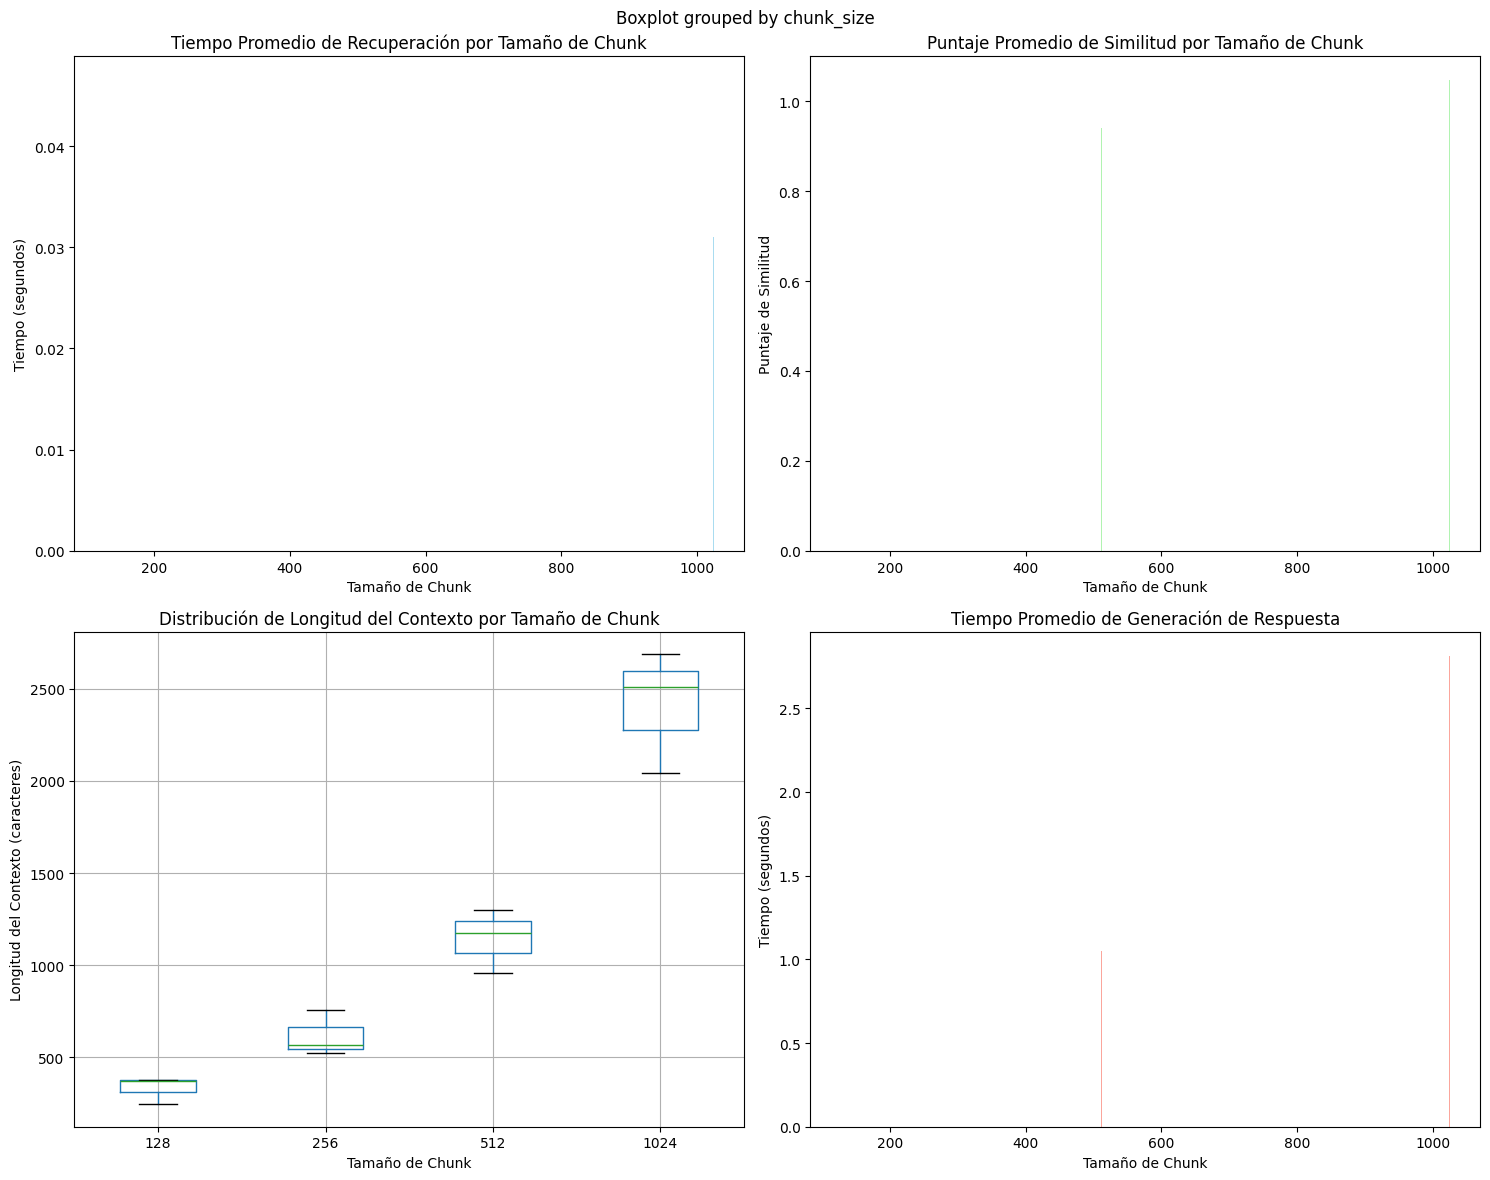

Chunk size óptimo: 256


In [18]:
score_df = calculate_optimization_score(performance_df, qa_df)
create_performance_visualizations(performance_df, qa_df)
best_chunk_size = int(score_df.iloc[0]['chunk_size'])
print("Chunk size óptimo:", best_chunk_size)
final_chunks = chunk_docs(documents, best_chunk_size, ["\n\n", "\n", " ", ""])